<a href="https://colab.research.google.com/github/tcotidiane33/AI/blob/master/naivesBayes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification with Naive Bayes (Xavier O'Rourke)

This project demonstrates my theoretical/mathematical understanding of machine learning algorithms.



In [50]:
import csv, scipy, scipy.stats, collections, itertools
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd

%matplotlib inline


## The data set


L'ensemble de données contient des informations du recensement des États-Unis et peut être téléchargé depuis https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data. La tâche de notre classifieur est de prédire si un individu a un revenu annuel supérieur à 50 000 $.


## Data Preprocessing (NOT MY OWN CODE)


In [77]:
raw_data = np.genfromtxt("/adult.data", dtype=str, delimiter=',', autostrip=True)
# Définir les noms des colonnes
column_names = ['employer', 'id', 'education', 'education_num', 'marital_status', 'occupation',
                'relationship', 'race', 'gender', 'capital_gain', 'capital_loss', 'hours_per_week',
                'native_country', 'income']

# Télécharger le jeu de données et attribuer les noms des colonnes
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
raw_data_df = pd.read_csv(data_url, names=column_names, header=None)

# Afficher les premières lignes du jeu de données pour vérification
print(raw_data_df.head())

             employer      id   education  education_num       marital_status  \
39          State-gov   77516   Bachelors             13        Never-married   
50   Self-emp-not-inc   83311   Bachelors             13   Married-civ-spouse   
38            Private  215646     HS-grad              9             Divorced   
53            Private  234721        11th              7   Married-civ-spouse   
28            Private  338409   Bachelors             13   Married-civ-spouse   

            occupation    relationship    race   gender  capital_gain  \
39        Adm-clerical   Not-in-family   White     Male          2174   
50     Exec-managerial         Husband   White     Male             0   
38   Handlers-cleaners   Not-in-family   White     Male             0   
53   Handlers-cleaners         Husband   Black     Male             0   
28      Prof-specialty            Wife   Black   Female             0   

    capital_loss  hours_per_week  native_country  income  
39             

In [78]:
# Convertir le tableau numpy en DataFrame
raw_data_df = pd.DataFrame(raw_data)

# Utiliser la méthode .info() pour obtenir des informations sur le DataFrame
raw_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   0       32561 non-null  object
 1   1       32561 non-null  object
 2   2       32561 non-null  object
 3   3       32561 non-null  object
 4   4       32561 non-null  object
 5   5       32561 non-null  object
 6   6       32561 non-null  object
 7   7       32561 non-null  object
 8   8       32561 non-null  object
 9   9       32561 non-null  object
 10  10      32561 non-null  object
 11  11      32561 non-null  object
 12  12      32561 non-null  object
 13  13      32561 non-null  object
 14  14      32561 non-null  object
dtypes: object(15)
memory usage: 3.7+ MB


In [79]:
# preview the dataset
raw_data_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


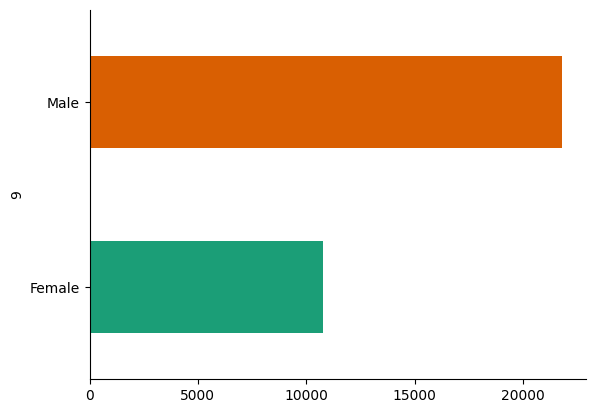

In [105]:
# Groupement des données par la colonne "income" et tracé d'un graphique en barres horizontales
raw_data_df.groupby(9).size().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()




In [81]:
# targets
target = ">50K"
target_column = raw_data[:,-1]
Y = (target_column == target).reshape(-1,1)
assert any(Y) and any(~Y), set(target_column)

features = [
    'age', 'workclass', 'fnlwgt','education', 'education_num', 'marital_status',
    'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss',
    'hours_per_week', 'native_country'
]

raw_features = raw_data[:,:-1] # drop the target
assert raw_features.shape[1] == len(features)


In [82]:
def preprocess_continuous(column):
    # convert continuous variables stored as strings to binary by comparing with the median
    float_column = column.astype(float)
    return (float_column > np.median(float_column)).astype(float).reshape(-1,1)


def preprocess_categorical(column):
    # convert categorical variables to indicator vectors
    values = sorted(set(column))
    if len(values) == 2:
        values = values[:1]
    return np.hstack([column.reshape(-1,1)==v for v in values]).astype(float)


preprocessor = collections.defaultdict(lambda: preprocess_categorical)
preprocessor.update(dict(
    age=preprocess_continuous,
    fnlwgt=preprocess_continuous,
    education_num=preprocess_continuous,
    capital_gain=preprocess_continuous,
    capital_loss=preprocess_continuous,
    hours_per_week=preprocess_continuous,
))


In [83]:
# apply appropriate preprocessor to each column of raw_features
X_list = [preprocessor[feature](raw_features[:,features.index(feature)]) for feature in features]
for feature, X in zip(features, X_list):
    assert X.shape[0] == raw_features.shape[0]
    print(X.shape[1], '\t', feature)

make_feature_names = lambda feature, dimension: ['%s_%.2i' % (feature, i) for i in range(dimension)]
binary_feature_names_list = [make_feature_names(feature, X.shape[1]) for feature, X in zip(features, X_list)]
binary_feature_names = list(itertools.chain(*binary_feature_names_list))

X = np.hstack(X_list)
assert set(X.flatten()) == {0.0, 1.0}
assert len(binary_feature_names) == X.shape[1]

b = raw_data[:,12].astype(float)

1 	 age
9 	 workclass
1 	 fnlwgt
16 	 education
1 	 education_num
7 	 marital_status
15 	 occupation
6 	 relationship
5 	 race
1 	 sex
1 	 capital_gain
1 	 capital_loss
1 	 hours_per_week
42 	 native_country


## (3 points) 1A: Naive Bayes: Maximum Likelihood (m.l.)
Assume we have dataset $\mathcal{D}=\left\{(\mathbf{x}_i,y_i\right)\}_{i=1,2,\ldots,n}$ where $\mathbf{x}_i\in\{0,1\}^d$, $y_i\in\{0,1\}$, $n$ is the number of data points and $d$ the number of features.
1. State the independence assumption of the naive Bayes classifier.
- Appropriately assume Bernoulli random variables. Letting $p(x_j=1|y=k) = \rho_{j,k}$ for $k=0,1$ and $p(y=1)=\mu$, derive the maximum likelihood $\rho_{j,k}$ and $\mu$ (that is, the parameters which maximise the likelihood).
- Implement a function which computes these maximum likelihood parameters, and call it on ```X_train, Y_train```.
- Plot the $\rho_{j,k}$ (vertical) vs. $j$ (horizontal) using ```plt.plot``` with ```marker='.'```, labeling appropriately.
- Print the number of $\rho_{j,k}$ which are zero.
- Explain the problems which zero- (or one-) valued $\rho_{j,k}$ can lead to.


### <span style="color:blue">Answer to Question 1A.1</span>

The independence assumption of the naieve Bayes classifier is that the class-conditional distributions of different features are all <b>independent</b> of each other, i.e.

$$
P( \mathbf{x}_i \Cond y_i) = \jprod P( x_{i, j} \Cond y_i)   
$$

This is clearly not the case for our data after preprocessing... for example, if the "Native country is United States" feature is 1, this means the "Native country is Mexico" feature must be 0.

### <span style="color:blue">Answer to Question 1A.2</span>

We can write the likelihood of seeing our data as: <br/> <br/>

$ P(\mathbf{x}, \mathbf{y}) = P(\mathbf{x} | \mathbf{y}) \: P(\mathbf{y}) $ <br/>

$
\implies  P(\mathbf{x}, \mathbf{y}) =  \iprod P(\mathbf{x}_i| y_i) \times \iprod P(y_i)
\qquad
$
(Assuming data are i.i.d) <br/>

Thus, the likelihood of seeing our data conditional on $\rho$ and $\mu$ is: <br/>

$ \implies P(\mathbf{x}, \mathbf{y} \; | \: \rho, \mu) =
\bigg[
\iprod \jprod
\rho_{j, 1}^{y_i x_{i, j}} \times
\rho_{j, 0}^{(1 - y_i) x_{i, j}} \times
(1 - \rho_{j, 1})^{y_i (1 - x_{i, j})} \times
(1 - \rho_{j, 0})^{(1 - y_i) (1 - x_{i, j})}
\bigg]
\times
\iprod \mu^{y_i} (1-\mu)^{1-y_i}
\qquad
$ (Using the naive Bayes assuption)<br/> <br/>

Taking the log of the likelihood yeilds: <br/> <br/>

$
ln\big(P(\mathbf{x}, \mathbf{y} \; | \: \rho, \mu)\big) =
$ <br/>
$
\bigg[ \isum \jsum
y_i x_{i, j} ln (\rho_{j, 1}) +
(1 - y_i) x_{i, j} ln (\rho_{j, 0}) +
y_i (1 - x_{i, j})ln (1 - \rho_{j, 1}) +
(1 - y_i)(1 - x_{i, j}) ln (1 - \rho_{j, 0})
\bigg] +
\isum y_i ln(\mu) + (1 - y_i)ln(1 - \mu)
$ <br/> <br/>

Setting the derivitive w.r.t $\rho_{j,1}$ equal to zero gives us: <br/> <br/>

$
\dfrac
{\isum y_i x_{j, i}}
{\rho_{j,1}}
=
\dfrac
{\isum y_i(1 - x_{i,j})}
{1 - \rho_{j,1}}
$
<br/>

$
\therefore \qquad
\rho_{j, 1} =
\dfrac
{\sum\limits_{i = 1}^{n} y_i x_{i,j}}
{\sum\limits_{i = 1}^{n} y_i}
\qquad
$
(This result harmonises with our intuition that the best estimate of the probability is the relative frequency)
<br/>

Similarly, taking the derivative of the log liklihood w.r.t $\rho_{j, 0} $ and setting equal to zero yeilds:
<br/>

$
\qquad
\dfrac
{\isum (1 - y_i) x_{i,j}}
{\rho_{j,0}}
=
\dfrac
{\isum (1 - y_i)(1 - x_{i,j})}
{1 - \rho_{j, 0}}
$
<br/>

$
\implies \qquad
\sum\limits_{i = 1}^{n} (1 - y_i) x_{i,j} -  \rho_{j,0}\sum\limits_{i = 1}^{n} (1 - y_i)x_{i,j}
=
\rho_{j,0}  \sum\limits_{i = 1}^{n} (1 - y_i) - \rho_{j,0}\sum\limits_{i = 1}^{n} (1 - y_i)x_{i,j}
$

$
\implies \qquad
\sum\limits_{i = 1}^{n} (1 - y_i) x_{i,j}
=
p_{j,0}  \sum\limits_{i = 1}^{n} (1 - y_i)
$

$
\therefore \qquad
\rho_{j, 0} =
\dfrac
{\isum (1 - y_i) x_{i,j} }
{ \isum (1 - y_i)}
\qquad
$
(Once again, this result seems intuitively correct)
</br>

Finally, taking the derivative of the log liklihood w.r.t $\mu$ and setting equal to zero yeilds:
<br/>  <br/>
$
\qquad
\sum\limits_{i = 1}^{n}
\dfrac
{y_i}
{\mu}
=
\sum\limits_{i = 1}^{n}
\dfrac
{1 - y_i}
{1 - \mu}
$ <br/> <br/>
$
\implies \qquad
\sum\limits_{i = 1}^{n} y_i -
\sum\limits_{i = 1}^{n} y_i \mu
=
\sum\limits_{i = 1}^{n} \mu -
\sum\limits_{i = 1}^{n} y_i \mu
$ <br/>

$
\therefore \qquad
\mu = \sum\limits_{i = 1}^{n}
\dfrac
{y_i}
{n}
= \bar{y}
\qquad
$
(As we should expect!)


### <span style="color:blue">Answer to Question 1A.3</span>

This function returns a tupple $(\hat{\mu}_{ML}, \hat{\rho}_{ML})$ containing the maximum liklehood estimators of $\mu$ and $\rho$. <br/>
$\rho$ is a $d \times 2$ array where the first column corresponds to MLE for $\rho_{j,0}$ and the second column corresponds to the MLE for $\rho_{j,1}$.


In [84]:
# Cellule de code <undefined>
# %% [code]
def maximum_likelihood(X, Y):
    """Takes data X and targets Y and returns the maximum liklihood estimators of μ and ρ"""
    n, d = X.shape
    μ = sum(Y)/n
    ρ = np.zeros((d, 2))
    ρ[:, 0] = (1 - Y).T@X / sum(1 - Y)
    ρ[:, 1] = Y.T@X / sum(Y)
    return (μ, ρ)


In [85]:
# Splitter le  dataset en  Training set(80%) and Test set (20%)
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)

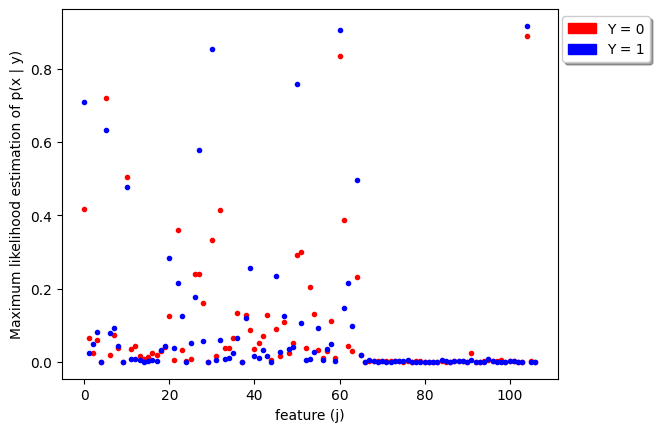

In [86]:
# %% [code]
# X_train = X
# Y_train = Y
μ, ρ = maximum_likelihood(X_train, Y_train)
plt.plot(ρ[:,0], 'r.', ρ[:,1], 'b.')

red_patch = mpatches.Patch(color='red', label='Y = 0')
blue_patch = mpatches.Patch(color='blue', label='Y = 1')
plt.xlabel('feature (j)')

plt.ylabel("Maximum likelihood estimation of p(x | y)")
plt.legend(handles = [red_patch, blue_patch], bbox_to_anchor=(1.2, 1), fancybox=True, shadow=True)

plt.show()

# %% [markdown]
### <span style="color:blue">Answer to Question 1A.5</span>


In [87]:
# %% [code]
μ, ρ = maximum_likelihood(X_train, Y_train)
num_zero = sum(sum(ρ == 0))
print("The number of maximum likelihood estimators equal to zero is %d" % num_zero)

The number of maximum likelihood estimators equal to zero is 5


# %% [markdown]
### <span style="color:blue">Answer to Question 1A.6</span>

If some of our $\rho_{j,k}$ are equal to 0 or 1, this will cause big problems when we try to make predictions based on our maximum liklehood estimators. To see this, notice that we will use the folowing formula to make our predictions: </br> </br>

$
\qquad
P(y = 1 \;|\; x) =
\dfrac
{P(x \;|\; y = 1)P(y = 1)}
{P(x)}
\qquad
\qquad
P(y = 0 \;|\; x) =
\dfrac
{P(x \;|\; y = 0)P(y = 0)}
{P(x)}
$
<br/>
<br/>
Which, by the naieve Bayes assumption is equivalent to: </br>

$
\qquad
P(y = 1 \;|\; x) =  
\dfrac
{\jprod P(x_j \;|\; y = 1) P(y = 1)}
{\jprod P(x_j)}
\qquad
\qquad
P(y = 0 \;|\; x) =
\dfrac
{\jprod P(x_j \;|\; y = 0) P(y = 0)}
{\jprod P(x_j)}
$ <br/> <br/>

Looking at this expression, we see that in a situation where a particular feature $x_j$ is zero while either $\rho_{j,0}$ or $\rho_{j,1}$ is one, we will assign a ZERO probability of Y taking the value 0/1 regardless of what the other features are. If a situation arrises where several $\rho_{j,k}$ are zero or one we may even end up precting that $P(y = 1 \;|\; x) = 0$ AND $P(y = 1 \;|\; x) = 0$ <br/>

For example, suppose in the training data everyone who was born in Qatar had an income above the threshold and everyone whose highest level of education is grade 9 had an income below the threshold. Then if our model was asked to predict whether a Qatari whose highest level of education is grade 9 earns above or below the income threshold, it would either be certian they are below or certian they are above depending on arbitrary details of how the prediction algorithm is implemented in code. This is obviously not good and should lower our trust in the model's predictions.

Cellule de texte <undefined>
# %% [markdown]
## (3 points) 1B: Naive Bayes: Maximum a Posteriori (m.a.p.)
Let $\rho_{j,k}\sim\text{Beta}(\beta)$, with p.d.f. $f_{\rho_{j,k}}(\rho)=\frac{\rho^{\beta-1}(1-\rho)^{\beta-1}}{Z(\beta)}$ where $Z$ is a normalisation factor. Assume a uniform prior for $\mu$.
1. Derive the maximum a posteriori $\rho_{j,k}$ and $\mu$ given the above prior.
- Implement a function which computes these maximum a posteriori parameters.
- Verify with ```assert np.allclose()``` that the m.a.p. solution with $\beta=1$ is identical to the m.l. solution.
- Call your function on ```X_train, Y_train``` with $\beta=10,100,1000$. For each case scatter plot the m.a.p. parameters vs. the m.l. parameters, all on one axis, colored and labelled appropriately.
- Give one example of the role of $\beta$ as evidenced by the plot.

Cellule de texte <undefined>
# %% [markdown]
### <span style="color:blue">Answer to Question 1B.1</span>

$
\hat{\rho}_{MAP}, \hat{\mu}_{MAP}  =
\argmax_{\rho, \mu}
\quad f(\rho, \mu \; | \; \mathbf{x}, \mathbf{y})
$ <br/> <br/>
$
\implies
\hat{\rho}_{MAP}, \hat{\mu}_{MAP}  =
\argmax_{\rho, \mu}
\quad
\dfrac
{P(\mathbf{x}, \mathbf{y}\; | \; \rho, \mu) \; f_{\rho}(\rho) \;f_{\mu}(\mu)}
{\int_{0}^{1}\int_{0}^{1}P(\mathbf{x}, \mathbf{y}\; | \; \rho', \mu') \; f_{\rho}(\rho') \;f_{\mu}(\mu') d\rho' d\mu'}
\qquad
$
(Bayes' theorem) <br/> <br/>

The denominator in the above expression is not relevant so we may discard it. <br/> <br/>
$
\implies
\hat{\rho}_{MAP}, \hat{\mu}_{MAP}  =
\argmax_{\rho, \mu}
\quad
P(\mathbf{x}, \mathbf{y}\; | \; \rho, \mu) \; f_{\rho}(\rho) \;f_{\mu}(\mu)
$ <br/>


Marginalising over y: <br/> <br/>
$
\implies
\hat{\rho}_{MAP}, \hat{\mu}_{MAP}  =
\argmax_{\rho, \mu}
\quad
P(\mathbf{x} \; | \;\mathbf{y}, \rho, \mu) \;  P(\mathbf{y} \; | \; \rho, \mu) \; f_{\rho}(\rho) \;f_{\mu}(\mu)
$ <br/> <br/>
$
\qquad \qquad \qquad \; \: =
\argmax_{\rho, \mu}
\quad
\big(
\iprod \jprod P(x_{i,j} \; | \; y_{i}, \rho_{j,k}, \mu) \;
\big)
\big(
\iprod  P(y_i \; | \; \rho_{j,k}, \mu) \;
\big)
\big(
\jprod f_{\rho}(\rho_{j, 0})f_{\rho}(\rho_{j, 1})  \;
\big)
f_{\mu}(\mu)
$
<br/> <br/>

From our earlier derivation we know: <br/> <br/>
$
\big(
\iprod \jprod P(x_{i,j} \; | \; y_{i}, \rho_{j,k}, \mu) \;
\big)
\big(
\iprod  P(y_i \; | \; \rho_{j,k}, \mu) \;
\big)
=
\bigg[
\iprod \jprod
\rho_{j, 1}^{y_i x_{i, j}} \times
\rho_{j, 0}^{(1 - y_i) x_{i, j}} \times
(1 - \rho_{j, 1})^{y_i (1 - x_{i, j})} \times
(1 - \rho_{j, 0})^{(1 - y_i) (1 - x_{i, j})}
\bigg]
\times
\iprod \mu^{y_i} (1-\mu)^{1-y_i}
\qquad
$
<br/> <br/>

Also, $\quad f_{\mu}(\mu) = 1, \quad$ (uniform prior on the interval $[0,1]$), and $\quad f_{\rho}(\rho_{j,k}) = \rho_{j,k}^{\beta-1}(1-\rho_{j,k})^{\beta-1} \quad $
(We may safely ignore the normalization constant).


Because the log function is monotonic, applying it to our posteriori likelihood will not change the argmax values.
<br/> <br/>

$
\implies
\hat{\rho}_{MAP}, \hat{\mu}_{MAP}  =
\argmax_{\rho, \mu} \Bigg\{
$
<br/>
$
\qquad \qquad
\isum \jsum
y_i x_{i, j} ln (\rho_{j, 1}) +
(1 - y_i) x_{i, j} ln (\rho_{j, 0}) +
y_i (1 - x_{i, j})ln (1 - \rho_{j, 1}) +
(1 - y_i)(1 - x_{i, j}) ln (1 - \rho_{j, 0})
\quad +
$
<br/>
$
\qquad \qquad
\isum y_i ln(\mu) + (1 - y_i)ln(1 - \mu)
\quad +
$
<br/>
$
\qquad \qquad
\jsum (\beta - 1)
\big(
ln(\rho_{j,0}) + ln(1 - \rho_{j,0}) + ln(\rho_{j,1}) + ln(1 - \rho_{j,1})
\big)
\qquad
\Bigg\}
$

Cellule de texte <undefined>
# %% [markdown]
Taking the derivative w.r.t $\rho_{j,1}$ and setting equal to zero yeilds:
<br/>
<br/>
$$
\dfrac
{\isum y_i x_{j, i}}
{\rho_{j,1}}
-
\dfrac
{\isum y_i(1 - x_{i,j})}
{1 - \rho_{j,1}}
+
(\beta - 1)(
\dfrac{1}{\rho_{j, 1}}
- \dfrac{1}{1 - \rho_{j, 1}})
= 0
$$
<br/> <br/>
$$
\implies \qquad
(1 - \rho_{j, 1}) \isum \big( y_i x_{j, i} \big)
-
\rho_{j, 1} \isum \big( y_i(1 - x_{i,j}) \big)
+
(\beta - 1)
(1 - 2\rho_{j, 1})
= 0
$$
<br/> <br/>

$
\implies \qquad
\beta - 1 + \isum y_i x_{i,j} =
\rho_{j, 1}\big( 2(\beta - 1) + \isum y_{i} \big)
$
<br/> <br/>
$
\therefore \qquad
\hat{\rho_{j, 1}}_{MAP} = \dfrac
{\beta - 1 + \isum y_i x_{i,j}}
{2(\beta - 1) + \isum y_i}
\qquad
$
Thankfully, this expression reduces to the previous result in the cause of a uniform prior ($\beta = 1$)

Cellule de texte <undefined>
# %% [markdown]
Similarly, taking the derivative w.r.t $\rho_{j,0}$ and setting equal to zero yeilds:
<br/>
<br/>
$
\qquad
\dfrac
{\isum (1 - y_i) x_{i,j}}
{\rho_{j,0}}
-
\dfrac
{\isum (1 - y_i)(1 - x_{i,j})}
{1 - \rho_{j, 0}}
+
(\beta - 1)(
\dfrac{1}{\rho_{j, 0}}
- \dfrac{1}{1 - \rho_{j, 0}})
= 0
$
<br/> <br/>
$
\implies \qquad
(1 - \rho_{j, 0}) \isum \big( (1 - y_i) x_{j, i} \big)
-
\rho_{j, 0} \isum \big( (1 - y_i)(1 - x_{i,j}) \big)
+
(\beta - 1)
(1 - 2\rho_{j, 0})
= 0
$
<br/> <br/>

$
\implies \qquad
\beta - 1 + \isum (1 - y_i) x_{i,j} =
\rho_{j, 0}\big( 2(\beta - 1) + \isum (1 - y_{i}) \big)
$
<br/> <br/>
$
\therefore \qquad
\hat{\rho_{j, 0}}_{MAP} = \dfrac
{\beta - 1 + \isum (1 - y_i) x_{i,j}}
{2(\beta - 1) + \isum (1 - y_i)}
\qquad
$
Again, this expression reduces to the previous result in the cause of a uniform prior ($\beta = 1$)

Cellule de texte <undefined>
# %% [markdown]
The procedure of setting the derivitive w.r.t $\mu$ equal to zero is identical to what we did in question 1A, and gives the result
<br/> <br/>
$
\hat{\mu}_{MAP} =
\dfrac
{y_i}
{n}
= \bar{y}
$

Cellule de texte <undefined>
# %% [markdown]
### <span style="color:blue">Answer to Question 1B.2</span>

This function returns a tupple $(\hat{\mu}_{MAP}, \hat{\rho}_{MAP})$ containing the maximum liklehood estimators of $\mu$ and $\rho$. <br/>
$\hat{\rho}_{MAP}$ is a $d \times 2$ array where the first column corresponds to MAP for $\rho_{j,0}$ and the second column corresponds to the MAP for $\rho_{j,1}$.


In [88]:
# %% [code]
def maximum_a_posteriori(X, Y, β) :
    n, d = X.shape
    mu = sum(Y)/n
    pjk = np.zeros((d, 2))
    pjk[:, 0] = (β - 1 + (1 - Y).T@X) / (2*(β - 1) + sum(1 - Y))
    pjk[:, 1] = (β - 1 + (Y.T@X)) / (2*(β - 1) + sum(Y))
    return (mu, pjk)

# %% [markdown]
### <span style="color:blue">Answer to Question 1B.3</span>

In [89]:
# %% [code]
μML, ρML = maximum_likelihood(X_train, Y_train)
μMAP, ρMAP = maximum_a_posteriori(X_train, Y_train, 1)


red_patch = mpatches.Patch(color='red', label='Y = 0')
blue_patch = mpatches.Patch(color='blue', label='Y = 1')

assert(np.allclose(μML, μMAP))
assert(np.allclose(ρML, ρMAP))

The mean of Y_train is: 0.239788


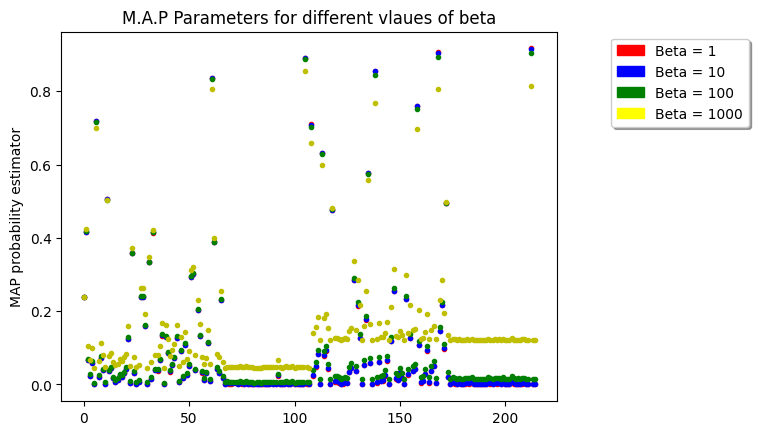

In [90]:
# %% [code]
β_values = [10, 100, 1000]
markers = ['r.', 'b.', 'g.', 'y.']
μML, ρML = maximum_likelihood(X_train, Y_train)

plt.plot(np.hstack((μML, ρML[:,0], ρML[:,1])), markers[0])

print("The mean of Y_train is: %f" % np.mean(Y_train))

for i in range(len(β_values)):
    μMAP, ρMAP = maximum_a_posteriori(X_train, Y_train, β_values[i])
    plt.plot(np.hstack((μMAP, ρMAP[:,0], ρMAP[:,1])), markers[i+1])

red_patch = mpatches.Patch(color='red', label='Beta = 1')
blue_patch = mpatches.Patch(color='blue', label='Beta = 10')
green_patch = mpatches.Patch(color='green', label='Beta = 100')
yellow_patch = mpatches.Patch(color='yellow', label='Beta = 1000')

plt.legend(handles = [red_patch, blue_patch, green_patch, yellow_patch], bbox_to_anchor=(1.4, 1), fancybox=True, shadow=True)
plt.title("M.A.P Parameters for different vlaues of beta")
plt.ylabel("MAP probability estimator")

plt.show()

# %% [markdown]
### <span style="color:blue">Answer to Question 1B.5</span>

In the graph above we see that higher values of $\beta$ correspond to stronger prior beliefs that each $\rho_{j,k}$ is close to $0.5$. <br/> <br/>
Interestingly, our MAP estimates of $\rho_{j, 0}$ (datapoints on the left side of the graph) are less sensitive to the value of $\beta$ than our MAP estimates of $\rho_{j,1}$ (datapoints on the right side of the graph). This is because the mean of $\mathbf{y}$ is less than 0.5, so in our training set there's more data available to us to inform our beliefs about $\rho_{j, 0}$ than there is for $\rho_{j,1}$. The more data we have with which to update our beliefs, the less important our prior is (as long as we have a modest non-zero prior).

To illustrate that a higher values of $\beta$ correspond to increasing confidence in the conditional probabilities not having extreme values, I've plotted the PDF of our prior for different values of beta below. You can see that when $\beta < 1$ we expect the probabilities to be close to zero or one, when $\beta= 1$ our prior is uniform, and when $\beta > 1$ we expect the conditional probabilities to be close to $0.5$.


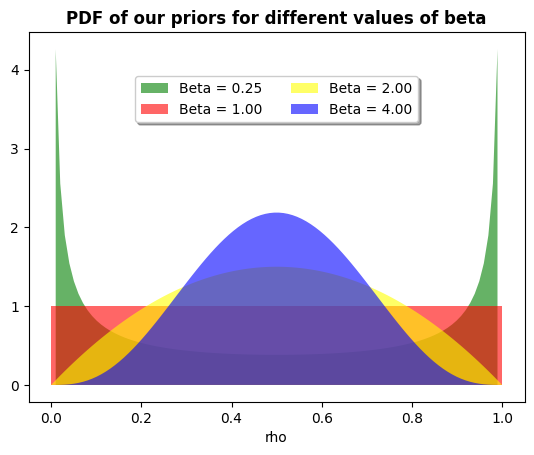

In [91]:
# %% [code]
from scipy.stats import beta

x = np.linspace(0, 1, 100)
beta_values = [0.25, 1, 2, 4]
colours = ['green', 'red', 'yellow', 'blue']

for i in range(len(beta_values)):
    y = beta.pdf(x, beta_values[i], beta_values[i])
    plt.fill_between(x, 0, y, facecolor=colours[i], alpha=0.6, label="Beta = %0.2f" % beta_values[i])



plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9),
          ncol=2, fancybox=True, shadow=True)

plt.title('PDF of our priors for different values of beta', fontsize=12, fontweight='bold')
plt.xlabel("rho", fontsize=10)
plt.show()

# %% [markdown]
## (2 points) 1C: Naive Bayes: Prediction
1. Derive the log predictive distribution $\log p(y=1|\mathbf{x},\{\rho_{j,k}\},\mu)$. Where appropriate, implement this by adding log probabilities instead of multiplying probabilities. Use ```np.logaddexp``` to add probabilities stored in log space.
- Call the above funcion on ```X_test``` using m.a.p. parameters computed with $\beta=2$.
- Plot a histogram of the probabilities (use ```np.exp``` on the log probabilities) using ```plt.hist``` with ```normed=True,histtype='step',label='your_label'```. Do this for the predictive test probabilities corresponding to ```Y_test==1``` and ```Y_test==0```, puting the histograms on the same plot, labeling appropriately.

Cellule de texte <undefined>
# %% [markdown]
### <span style="color:blue">Answer to Question 1C.1</span>

$$
P(y = 1 \;|\; \mathbf{x}, \rho, \mu) \quad = \quad
\dfrac
{P(\mathbf{x} \;|\; y = 1, \rho, \mu)\; P(y = 1 \;|\ \rho, \mu)}
{P(\mathbf{x} \;|\; \rho, \mu)}
$$
<br/> <br/>

$$
= \quad
\dfrac
{P(\mathbf{x} \;|\; y = 1, \rho, \mu)\; P(y = 1 \;|\ \rho, \mu)}
{P(\mathbf{x} \;|\; y = 1, \rho, \mu)\; P(y = 1 \;|\ \rho, \mu) +
P(\mathbf{x} \;|\; y = 0, \rho, \mu)\; P(y = 0 \;|\ \rho, \mu)}
$$
<br/> <br/>

$$
\qquad \qquad \qquad \quad = \quad \dfrac
{\jprod P(x_j \;|\; y = 1, \rho, \mu) \; P(y = 1 \;|\ \rho, \mu)}
{ \jprod \bigg(
P(x_j \;|\; y = 1, \rho, \mu)\; P(y = 1 \;|\ \rho, \mu)
\bigg) +
\jprod \bigg(
P(x_j \;|\; y = 0, \rho, \mu)\; P(y = 0 \;|\ \rho, \mu)
\bigg) }
$$

<br/><br/>

$$
= \quad \dfrac
{\bigg(
\jprod \rho_{j, 1}^{x_j}(1 - \rho_{j, 1})^{1-x_j}
\bigg) \cdot \mu}
{\bigg(
\jprod \rho_{j, 1}^{x_j}(1 - \rho_{j, 1})^{1-x_j}
\bigg) \cdot \mu
+
\bigg(
\jprod \rho_{j, 0}^{x_j}(1 - \rho_{j, 0})^{1-x_j}
\bigg) \cdot (1 - \mu)
}
$$
<br/> <br/>

$$
\therefore \qquad
ln \bigg(
P(y = 1 \;|\; \mathbf{x}, \rho, \mu)
\bigg)
\quad = \quad
\jsum x_j ln(\rho_{j, 1}) + \jsum(1 - x_j)ln(1 - \rho_{j, 1}) + ln(\mu) \qquad  -
\qquad \qquad \qquad \qquad
ln \Bigg( \bigg(
\jprod \rho_{j, 1}^{x_j}(1 - \rho_{j, 1})^{1-x_j}
\bigg) \cdot \mu
+
\bigg(
\jprod \rho_{j, 0}^{x_j}(1 - \rho_{j, 0})^{1-x_j}
\bigg) \cdot (1 - \mu) \Bigg)
$$

<br/> <br/>

This is the expression for the log predictive distribution the question asks for. However when I actually implement this in code, I will reffer to the expression below instead:

<br/><br/>

$$
P(y = 1 \;|\; \mathbf{x}, \rho, \mu)
\quad = \quad
\dfrac
{exp \bigg(
\jsum x_j ln(\rho_{j, 1}) + \jsum(1 - x_j)ln(1 - \rho_{j, 1}) + ln(\mu)
\bigg)}
{exp \bigg(
\jsum x_j ln(\rho_{j, 1}) + \jsum(1 - x_j)ln(1 - \rho_{j, 1}) + ln(\mu)
\bigg) +
exp \bigg(
\jsum x_j ln(\rho_{j, 0}) + \jsum(1 - x_j)ln(1 - \rho_{j, 0}) + ln(1 - \mu)
\bigg)}
$$

In [92]:
# %% [code]
def log_prediction_naieve_bayes(X, μ, ρ):
    # X is either a vector of length d, or a matrix of size n x d
    # ρ has shape dx2

    ρ_0 = ρ[:, 0]  # probabilities conditional on y == 0
    ρ_1 = ρ[:, 1]  # probabilities conditional on y == 1

    # We first calculate the log probabilities of P(x | y==1) and P(x | y == 0) seperately
    log_p_x_given_y0 = X @ np.log(ρ_0) + (1 - X) @ np.log(1 - ρ_0)
    log_p_x_given_y1 = X @ np.log(ρ_1) + (1 - X) @ np.log(1 - ρ_1)

    # Convert these log probabilities back to actual probabilities so we can use Bayes theorem

    p_x_given_y0 = np.exp(log_p_x_given_y0)
    p_x_given_y1 = np.exp(log_p_x_given_y1)

    # Now apply Bayes theorem
    p_y1_given_x = (p_x_given_y1 * μ) / (p_x_given_y1 * μ + p_x_given_y0 * (1 - μ))

    return np.log(p_y1_given_x)


In [93]:
# %% [code]
# Call our prediction function with the MAP estimates from our training data, beta = 2

μ, ρ = maximum_a_posteriori(X_train, Y_train, 2)


X_train_y0 = X_train[Y_train[:, 0] == 0, :]
X_train_y1 = X_train[Y_train[:, 0] == 1, :]

log_probabilities_y0 = log_prediction_naieve_bayes(X_train_y0, μ, ρ)
log_probabilities_y1 = log_prediction_naieve_bayes(X_train_y1, μ, ρ)


probabilities_y0 = np.exp(log_probabilities_y0)
probabilities_y1 = np.exp(log_probabilities_y1)


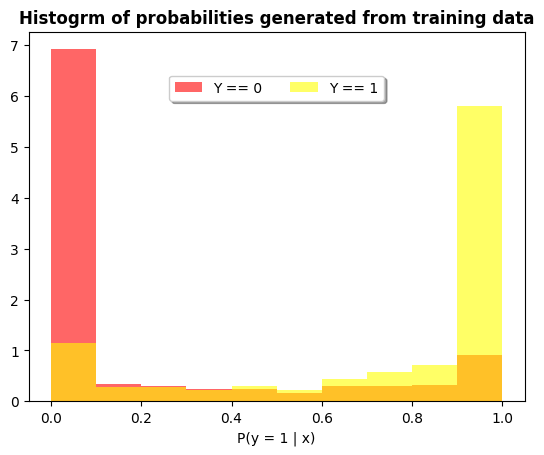

In [94]:
# %% [code]
plt.hist(probabilities_y0, density=True, label='Y == 0', facecolor='red', alpha=0.6)
plt.hist(probabilities_y1, density=True, label='Y == 1', facecolor='yellow', alpha=0.6)

plt.legend(loc='upper center', bbox_to_anchor=(0.5, 0.9),
          ncol=2, fancybox=True, shadow=True)
plt.title('Histogrm of probabilities generated from training data', fontsize=12, fontweight='bold')
plt.xlabel('P(y = 1 | x)')
plt.show()

# %% [markdown]
We see that, with the training data, the values our model gives for $P(y = 1 \;|\; \mathbf{x})$ are very small more often when $y = 0$, and are very large more often when $y = 1$. This is encouraging but still need to test our model on some cross-validation data before trying to apply it to new examples.

Interestingly, extreme values of $P(y = 1 \;|\; \mathbf{x})$ appear far more often than values closer to $0.5$. I'm not quite sure why this is so.

Cellule de texte <undefined>
# %% [markdown]
## (2 points) 1D: Naive Bayes: Evaluation
1. Write a function ```evaluate``` which takes data ```X,Y``` and model parameters $\rho_{j,k}$ and $\mu$, and returns a dict with keys ```mean_logp_true``` (for the mean predictive log probability of the ground truth labels ```Y``` given the data matrix ```X``` and ```percent_correct``` (for the percent correctly classified, assuming we classify each datum into the class with maximum predictive probability).
- Write a function ```cross_validate(beta, nfolds, X, Y)``` which performs cross validation with ```nfolds``` folds, for hyper parameter $\beta$. For each split, call your ```evaluate``` function, and return a ```dict``` with averaged results for each evaluation metric. You can make use of our ```xval_inds``` function.
- For $\beta$ in ```np.logspace(np.log10(2),2,32)``` compute the evaluation metrics on the test set, ```X_test, Y_test```, as well as the cross-validated estimates. Make one plot for each metric, showing both results on each (for a total of four curves). Label appropriately.


In [95]:
# %% [code]
def xval_inds(ndata, nfolds):
    # return a list of (trainind, testind) pairs for ndata data points and nfolds xval folds
    assert ndata % nfolds == 0
    nchunk = int(ndata / nfolds)
    itest = [list(range(i*nchunk,(i+1)*nchunk)) for i in range(int(nfolds))]
    itrain = [sorted(set(range(ndata)).difference(set(i))) for i in itest]
    return list(zip(itrain, itest))


In [96]:
# %% [code]
def evaluate(X, Y, μ, ρ):
    """
    Returns a dictionary (results), where results[k] is a 2 tupple.

    The first element of the tupple is the average log
    probability our model gives for P(Y = 1 | X) when the ground truth is Y = k.

    The second element of the tupple is the percentage of correctly classified examples
    when the ground truth is y = k
    """
    # X has dimensions n x d
    # Y has dimensions n x 1
    # ρ has dimensions d x 2

    X_y0 = X[Y[:, 0] == 0, :] # Exaples where Y == 0
    X_y1 = X[Y[:, 0] == 1, :] # Examples where Y == 1

    log_probabilities_y0 = log_prediction_naieve_bayes(X_y0, μ, ρ)
    log_probabilities_y1 = log_prediction_naieve_bayes(X_y1, μ, ρ)

    percent_correct_y0 = np.mean(np.exp(log_probabilities_y0) < 0.5)*100
    percent_correct_y1 = np.mean(np.exp(log_probabilities_y1) > 0.5)*100


    results = {}
    results[0] = (np.mean(log_probabilities_y0), percent_correct_y0)
    results[1] = (np.mean(log_probabilities_y1), percent_correct_y1)

    return results

In [97]:
# %% [code]
def cross_validate(β, nfolds, X, Y):
    n, d = X.shape
    indexes = xval_inds(n, nfolds)

    sum_results = {}
    for k in [0, 1]:
        sum_results[k] = (0, 0)



    for (itrain, icross_validate) in indexes:

        # Separate data into training and cross-validation
        X_train = X[itrain, :]
        Y_train = Y[itrain]

        X_cross_validate = X[icross_validate, :]
        Y_cross_validate = Y[icross_validate]

        # Use training data to pick parameters for our model
        μ, ρ = maximum_a_posteriori(X_train, Y_train, β)

        # Evaluate performance on the cross validation data
        results = evaluate(X_cross_validate, Y_cross_validate, μ, ρ)

        # Add together the results of the evaluation for each fold
        for k in sum_results:
            sum_results[k] = tuple(map(sum, zip(results[k], sum_results[k])))

    # divide by nfolds to get the average
    average_results = {}
    for k in sum_results:
        average_results[k] = tuple(map(lambda x: x / nfolds, sum_results[k]))

    return average_results


In [98]:
def xval_inds(ndata, nfolds):
    # return a list of (trainind, testind) pairs for ndata data points and nfolds xval folds
    assert ndata % nfolds == 0, f"Number of data points, {ndata}, must be divisible by the number of folds, {nfolds}"
    nchunk = int(ndata / nfolds)
    itest = [list(range(i*nchunk,(i+1)*nchunk)) for i in range(int(nfolds))]
    itrain = [sorted(set(range(ndata)).difference(set(i))) for i in itest]
    return list(zip(itrain, itest))

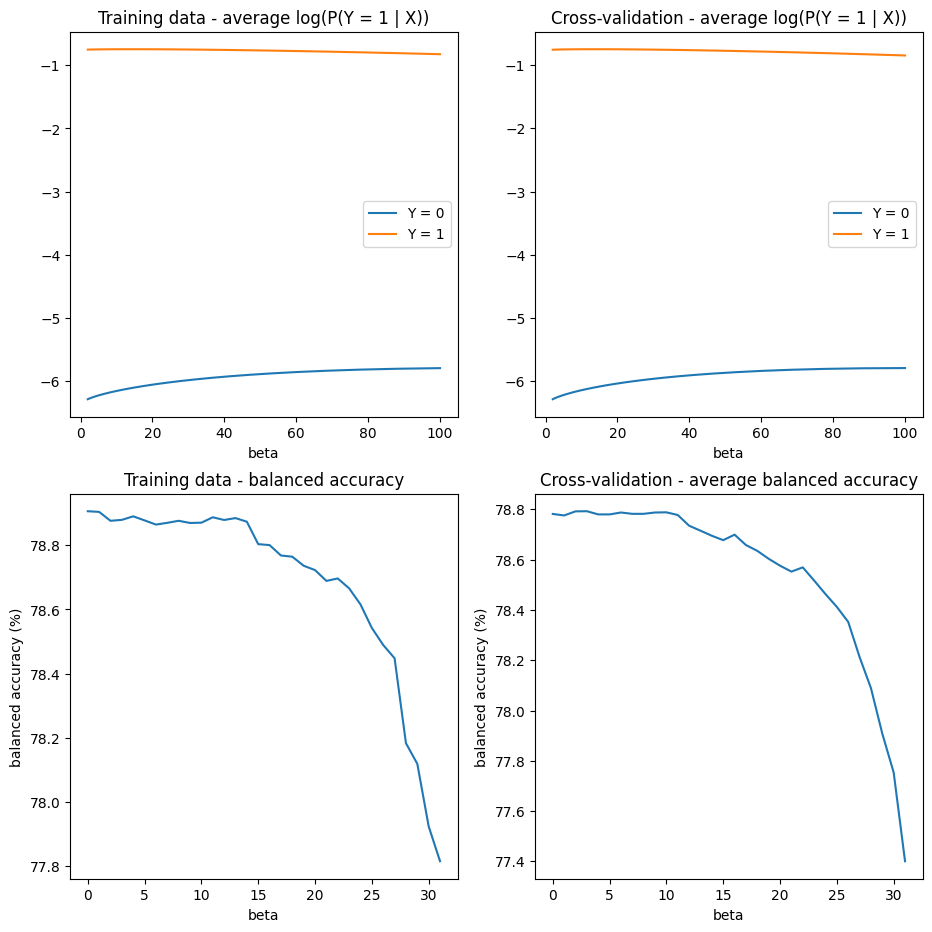

In [99]:
# %% [code]
train_results_y0 = []
train_results_y1 = []

cv_results_y0 = []
cv_results_y1 = []

β_values = np.logspace(np.log10(2),2,32)

for β in β_values:
    μ, ρ = maximum_a_posteriori(X_train, Y_train, β)

    train_results = evaluate(X_train, Y_train, μ, ρ)

    train_results_y0.append(train_results[0])
    train_results_y1.append(train_results[1])

    cv_results = cross_validate(β, 8, X_train, Y_train)

    cv_results_y0.append(cv_results[0])
    cv_results_y1.append(cv_results[1])



fig = plt.figure(figsize=(11,11))

ax = fig.add_subplot(221)
ax.plot(β_values, [a[0] for a in train_results_y0], label = "Y = 0")
ax.plot(β_values, [a[0] for a in train_results_y1], label = "Y = 1")
ax.set_title("Training data - average log(P(Y = 1 | X))")
ax.set_xlabel("beta")
ax.legend()

ax = fig.add_subplot(222)
ax.plot(β_values, [a[0] for a in cv_results_y0], label = "Y = 0")
ax.plot(β_values, [a[0] for a in cv_results_y1], label = "Y = 1")
ax.set_title("Cross-validation - average log(P(Y = 1 | X))")
ax.set_xlabel("beta")
ax.legend()


# When we plot the average accuracy of the predictions, I think it's most appropriate
# to plot the average "balanced" accuracy. Balanced accuracy is equal to
# 0.5*(tp/p + tn/n)

train_average_accuracy_y0 = [a[1] for a in train_results_y0]
train_average_accuracy_y1 = [a[1] for a in train_results_y1]

train_balanced_accuracy = [sum(a)/2 for a in zip(train_average_accuracy_y0, train_average_accuracy_y1)]

ax = fig.add_subplot(223)
ax.plot(train_balanced_accuracy)
ax.set_title("Training data - balanced accuracy")
ax.set_xlabel("beta")
ax.set_ylabel("balanced accuracy (%)")



cv_average_accuracy_y0 = [a[1] for a in cv_results_y0]
cv_average_accuracy_y1 = [a[1] for a in cv_results_y1]

cv_balanced_accuracy = [sum(a)/2 for a in zip(cv_average_accuracy_y0, cv_average_accuracy_y1)]


ax = fig.add_subplot(224)
ax.plot(cv_balanced_accuracy)
ax.set_title("Cross-validation - average balanced accuracy")
ax.set_xlabel("beta")
ax.set_ylabel("balanced accuracy (%)")

plt.show()


## (2 points) 1E: Naive Bayes: Discussion
1. Explain the shortcomings of our preprocessing of (a) continous variables, and (b) categorical variables. Make note of the assumptions of our model.
- Suggest improvements to our data processing pipeline, both in terms of the representation and the model.
- Consider the distribution $p(a,b,c)$ where all three variables are binary. How many parameters are needed to specify this distribution (a) in general and (b) if it factorises as $p(a|c)p(b|c)p(c)$?


### <span style="color:blue">Answer to Question 1E.1 (a)</span>

We processed our continuous variables by converting each continuous variable to a single binary feature, setting that feature to zero when the variable's value is less than or equal the median, and setting it to one otherwise.

The most obvious shortcomming of this approach is that we are discarding enormous amounts of valuable information! For example- the median hours worked per week is 40, meaning the feature corresponding to this information is 0 when hours worked <= 40 and 1 otherwise. However, I am extremely confident that a person who works 40 hours per week is more likely to earn above 50k USD per year compared with a person who works 20 hours per week.

Cellule de texte <undefined>
# %% [markdown]
### <span style="color:blue">Answer to Question 1E.1 (b)</span>

We processed our categorical variables by creating m features for each cattegory (where m is the number of different values the variable takes in our dataset) and setting one of these m features to 1. A shortcomming of this approach is that it is in direct opposition to our naieve Bayes assumption. The naieve bayes assumption is that the distributions of different features are independent of each other, however it is clear that the value of the feature corresponding to "This individual's highest level of education is a high school degree" is <i>deeply entangled</i> with the value of the feature corresponding to "This individual's highest level of education is a bachelor's degree"". If the value of either feature is 1, the value of the other is necessarily 0!

### <span style="color:blue">Answer to Question 1E.2</span>

If I were to suggest an improvment to our data processing pipeline I would process our continuous variables not by converting them to a binary feature, but rather by normalizing them to values between 0 and 1. This would alieviate the issue of throwing too much data away during preprocessing.

I would then use a logistic regression model, assuming that $P(y = 1 \;|\; \mathbf{x}) = \sigma(\mathbf{w}^T \mathbf{x})$ and find the MAP solution of $\mathbf{w}$. (With some prior which assumed the magnitude of the weights was is not extremely high). This model would actually require fitting fewer paramaters, and at the same time would not be making the demonstrably false naieve Bayes assumption.

## (3 points) 2A: Representation Proof
Consider a parametric model governed by the parameter vector $\mathbf{w}$ together with a dataset of input values $\mathbf{x}_1,\ldots,\mathbf{x}_N$ and a nonlinear feature mapping $\phi(\mathbf{x})$. Suppose that the dependence of the error function on $\mathbf{w}$ takes the form $J(\mathbf{w}) = f(\mathbf{w}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}^\top \phi(\mathbf{x}_N)) + g(\mathbf{w}^\top \mathbf{w})$
where $g(\cdot)$ is a monotonically increasing function. By writing $\mathbf{w}$ in the form
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp
$$
show that the value of $\mathbf{w}$ that minimizes $J(\mathbf{w})$ takes the form of a linear combination of the basis functions $\phi(\mathbf{x}_n)$ for $n = 1, \ldots, N$.

### <span style="color:blue">Answer to Question 2A</span>

If we evaluate one column of $\phi(\mathbf{x}_n)$ at all $N$ data points, we get an $N$ dimensional vector. Do this for all $d$ columns of $\phi$ and we have $d$ $N$-dimensional vectors (which span a $d$-dimensional subspace of $\mathbb{R}^N$).
Let us decompose $\mathbf{w}$ into two components, a vector inside this $d$-dimensional subspace, plus a vector orthogonal to it. i.e.
$$
\mathbf{w} = \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n) + \mathbf{w}_\perp = \mathbf{w}_{||} + \mathbf{w}_\perp
$$

(Where $\mathbf{w}_{||}$ lies on the surface spanned by the basis functions and $\mathbf{w}_\perp$ is orthoganal to this surface)

Now we may rewrite our cost function as:

$$
J(\mathbf{w}) = f\bigg(
(\mathbf{w}_{||} + \mathbf{w}_\perp)^\top \phi(\mathbf{x}_1), \ldots, (\mathbf{w}_{||} + \mathbf{w}_\perp)^\top \phi(\mathbf{x}_N)
\bigg) + g\bigg(
(\mathbf{w}_{||} + \mathbf{w}_\perp)^\top (\mathbf{w}_{||} + \mathbf{w}_\perp)
\bigg)
$$

But since $\mathbf{w}_{||}$ is normal to the surface spanned by the basis functions, we know $\mathbf{w}_{\perp}^\top \phi(\mathbf{x}_n) = 0 \;\forall \; n$. Also, $\mathbf{w}_{||}^\top \mathbf{w}_\perp = \mathbf{w}_{\perp}^\top \mathbf{w}_{||} = 0 $

$$
\implies J(\mathbf{w}) = f\bigg(
\mathbf{w}_{||}^\top \phi(\mathbf{x}_1), \ldots, \mathbf{w}_{||}^\top \phi(\mathbf{x}_N)
\bigg) + g\bigg(
\mathbf{w}_{||}^\top \mathbf{w}_{||} + \mathbf{w}_\perp^{\top} \mathbf{w}_\perp
\bigg)
$$

Since g is monotonically increasing, this cost function is minimized when $\mathbf{w}_\perp = \mathbf{0}$

$$
\implies \mathbf{w} = \mathbf{w}_{||} =  \sum_{n=1}^N \alpha_n \phi(\mathbf{x}_n)
$$

<br/>
$ \therefore \quad $ the value of $\mathbf{w}$ that minimizes $J(\mathbf{w})$ is a linear combination of the basis functions.



## (2 points) 2B: Maximum likelihood (ML) and Maximum A Posteriori (MAP)
We assume data samples $X_n = \{ x_1,\dots,x_n \}$ are generated i.i.d. from a uniform distribution
$ \DUniform{x}{0}{\theta} $ between $ 0 $ and an unknown positive parameter $\theta$:
$$
   p(x \Cond \theta) = \DUniform{x}{0}{\theta} =
\begin{cases}
 1/\theta & 0 \leq x \leq \theta \\
 0        & \textrm{otherwise} \\
\end{cases}
$$

Assume the data samples $ X_4 = \{ 5, 7, 3, 9 \}$ have been observed.

1. Calculate $\theta_{ML} = \argmax_{\theta} p(X_4 \Cond \theta)$,
the maximum likelihood estimate of $\theta$ for the observed data.

- Calculate $p(\theta \Cond X_4)$, the posterior distribution of $\theta$ given that the
data $ X_4 $ have been observed and
the initial distribution for $\theta$ is given as $p(\theta) = p(\theta \Cond X_0) = \DUniform{x}{0}{10}$.

- Calculate $\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4)$, the maximum a posteriori
estimate of $\theta$ given the data $ X_4 $ and the initial distribution $p(\theta)$ as in the previous question.

- Calculate $\theta_{ML}$, $p(\theta \Cond X_4)$, and $\theta_{MAP}$ for the case that the observed data are $ X_4 = \{ 9, 5, 7, 3 \}$ instead of the $ X_4 = \{ 5, 7, 3, 9 \}$ given above.


### <span style="color:blue">Answer to Question 2B.1</span>

$$\theta_{ML} = \argmax_{\theta} p(X_4 \Cond \theta)$$

$$ \implies \theta_{ML} = \argmax_{\theta} \prod \limits_{i = 1}^{4} p(x_i \Cond \theta)$$

$$
 \implies \theta_{ML} = \argmax_{\theta}
\begin{cases}
 (1/\theta)^4 & \theta \geq 9 \\
 0        & \textrm{otherwise} \\
\end{cases}
$$

Clearly, the expression $ (1/\theta)^4 $ is monotonically decreasing.

$$
\therefore \qquad \theta_{ML} = 9
$$


### <span style="color:blue">Answer to Question 2B.1</span>

$$
p(\theta \Cond X_4) = \dfrac
{p(X_4 \Cond \theta) p(\theta)}
{p(X_4)}
$$

$$
\implies p(\theta \Cond X_4) = \dfrac
{\prod \limits_{i = 1}^{4} p(x_i \Cond \theta) p(\theta)}
{\int \prod \limits_{i = 1}^{4} p(x_i \Cond \theta') p(\theta') d \theta'}
$$

Since our largest observation is $9$, $p(x_i \Cond \theta')$ is zero for all $\theta' \leq 9$. Also our prior, $p(\theta')$, is zero for all $\theta' \geq 10$

$$
\implies
p(\theta \Cond X_4) = \begin{cases}
\dfrac
{(1/\theta)^4 (1/10)}
{\int \limits_{9}^{10} (1/\theta')^4 (1/10) d \theta'}
& 9 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$

$$
\therefore \qquad
p(\theta \Cond X_4) = \begin{cases}
\dfrac
{2187000}
{271}
\dfrac{1}{\theta^4}
& 9 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$


### <span style="color:blue">Answer to Question 2B.3</span>

Looking at our expression above for $p(\theta \Cond X_4)$ it is clear to see that this pdf is maximized when $\theta = 9$

$$
\therefore \quad
\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4) = 9
$$


### <span style="color:blue">Answer to Question 2B.3</span>

The data are i.i.d, so permuting the order of observations should make no difference to our ML/MAP estimators, and it doesn't!

To demonstrate this (in painstaking detail...), I will calculate the MAP estimator again, but this time using FOUR updates on the prior (one for each observation) instead of what I did before where I updated just once by taking into account all the data at the same time. Let $ X_4 = \{ 5, 7, 3, 9 \}$

$$
p(\theta \Cond X_0) = \DUniform{x}{0}{10} = 1/10
$$

Now use this to calculate $p(\theta \Cond X_1)$, remembering $X_1 = 5$.

$$
p(\theta \Cond X_1) = \dfrac
{p(X_1 \Cond \theta) p(\theta \Cond X_0 )}
{\int p(X_1 \Cond \theta') p(\theta \Cond X_0') d \theta'}
$$

$$
\implies
p(\theta \Cond X_1) = \begin{cases}
\dfrac
{1/\theta (1/10)}
{\int \limits_{5}^{10} 1/\theta' (1/10) d \theta'}
& 5 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$

$$
\therefore \qquad
p(\theta \Cond X_1) = \begin{cases}
\dfrac
{1}
{ln(2)}
\dfrac{1}{\theta}
& 5 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$



Now use this to calculate $p(\theta \Cond X_2)$, (remembering our second observation was $7$). Before this update prior distribution on $\theta$ is $p(\theta \Cond X_1)$

$$
p(\theta \Cond X_2) = \dfrac
{p(X_2 \Cond \theta, X_1) p(\theta \Cond X_1 )}
{\int p(X_1 \Cond \theta') p(\theta \Cond X_1') d \theta'}
$$

$$
\implies
p(\theta \Cond X_1) = \begin{cases}
\dfrac
{1/\theta \dfrac{1}{ln(2)} \dfrac{1}{\theta}}
{\int \limits_{7}^{10} 1/\theta' \dfrac{1}{ln(2)} \dfrac{1}{\theta'} d \theta'}
& 7 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$

$$
\therefore \qquad
p(\theta \Cond X_2) = \begin{cases}
\dfrac{70}{3}
\dfrac{1}{\theta^2}
& 7 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$



Now use this to calculate $p(\theta \Cond X_3)$, (remembering our third observation was $3$). Before this update prior distribution on $\theta$ is $p(\theta \Cond X_2)$

$$
p(\theta \Cond X_3) = \dfrac
{p(X_3 \Cond \theta, X_2) p(\theta \Cond X_2 )}
{\int p(X_3 \Cond \theta', X_2) p(\theta' \Cond X_2) d \theta'}
$$

$$
\implies
p(\theta \Cond X_3) = \begin{cases}
\dfrac
{\dfrac{1}{\theta} \dfrac{70}{3}
\dfrac{1}{\theta^2}}
{\int \limits_{7}^{10} \dfrac{1}{\theta'}  \dfrac{70}{3}
\dfrac{1}{\theta'^2} d \theta'}
& 7 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$

$$
\therefore \qquad
p(\theta \Cond X_3) = \begin{cases}
\dfrac{9800}{51}
\dfrac{1}{\theta^3}
& 7 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$


Now, (finaly), use this to calculate $p(\theta \Cond X_4)$, (remembering our third observation was $9$). Before this update prior distribution on $\theta$ is $p(\theta \Cond X_3)$

$$
p(\theta \Cond X_4) = \dfrac
{p(X_4 \Cond \theta, X_3) p(\theta \Cond X_3 )}
{\int p(X_4 \Cond \theta', X_3) p(\theta' \Cond X_3) d \theta'}
$$


$$
\implies
p(\theta \Cond X_4) = \begin{cases}
\dfrac
{
\dfrac{1}{\theta}
\dfrac{9800}{51}
\dfrac{1}{\theta^3}
}
{
\int \limits_{9}^{10}
\dfrac{1}{\theta'}
\dfrac{9800}{51}
\dfrac{1}{\theta'^3} d \theta'}
& 9 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$

$$
\therefore \qquad
p(\theta \Cond X_4) = \begin{cases}
\dfrac
{2187000}
{271}
\dfrac{1}{\theta^4}
& 9 \leq \theta \leq 10 \\ \\
0 & \textrm{otherwise} \\
\end{cases}
$$


$$
\therefore \quad
\theta_{MAP} = \argmax_{\theta} p(\theta \Cond X_4) = 9
$$

Just like before! That was pretty painful :(


## (2 points) 2C: Laplace Approximation
The function
$$
  f(z) = z^k e^{-z^2/2} \qquad \qquad z \in [0, \infty), \qquad k > 0
$$
can be considered as an (unnormalised) probability density.

1. Verify that it is possible to approximate $ f(z) $ with the Laplace Approximation.

- Using the Laplace Approximation, find the mean and the variance of the Normal Distribution which best approximates the normalised version of $ f(z) $.

- The analytical form of the normalisation of $ f(x) $ is not so easy to find. Therefore, use Python to implement a numerical approximation using $ N = 100 $ identically sized intervals between $ 0 $ and $ a = 10 $ to calculate the normalisation
$$
  \int_0^{\infty} f(z) \mathrm{d}z
  \approx \int_0^{a} z^k e^{-z^2/2} \mathrm{d}z
  \approx \sum_{i=1}^{100} \dots
$$
and report the results for the normalisation with a
precision of $5$ digits after the comma for the three cases $ k = \{0.5, 3, 5 \}$.
            
- For each of the three cases $ k = \{0.5, 3, 5 \}$, plot the normalised function $ f(z) $
and the corresponding Normal Distribution with parameters  resulting from the Laplace Approximation.

- Why is it reasonable to replace the upper limit of $ \infty$ with $ a = 10 $ ?


### <span style="color:blue">Answer to Question 2C.1</span>

To approximate this distribution with a gaussian we must check this distribution has a mode. To do this compute the first derivative:

$$
\dfrac{df}{dz} = k z^{k-1} e^{-z^2/2} + z^{k}(-z e^{-z^2/2})
$$

$$
\implies \dfrac{df}{dz} = z^{k-1} e^{-z^2/2} (k - z^2)
$$

Setting this derivative equal to zero yeilds

$$
z^2 = k \implies z = \sqrt{k} \quad
$$

note: we take the positive solution since our distribution is only defined on $z \in [0, \infty)$

To establish we have found a maxima, take the second derivative:

$$
\dfrac{d^2f}{dz^2} = e^{-z^2/2} z^{k-2}
\big(
-k + k^2 - z^2 - 2 k z^2 + z^4
\big)
$$

... and substitute in $z = \sqrt{k}$



$$
\frac{d^2 f}{dz^2}\Bigr|_{\substack{z=\sqrt{k}\\}} = e^{-k/2} z^{k-2} \big(
-k + k^2 - k - 2k^2 + k^2
\big)
$$

$$
\implies \frac{d^2 f}{dz^2}\Bigr|_{\substack{z=\sqrt{k}\\}} = -2k e^{-k/2} z^{k-2}
$$

$$
\implies \frac{d^2 f}{dz^2}\Bigr|_{\substack{z=\sqrt{k}\\}} \leq 0
$$

Since the derivative is continuous, there is only one critical point in the interval where the function is defined, and at this point the second derivative is negative, the critical point must be a global maxima.

The other condition we require to hold so that we may approximate this distribution with a gaussian is that $\dfrac{d^2}{dz^2} \ln f(z) \Bigr|_{z = \sqrt{k}}$ be defined.

$$
\ln f(z) = k \ln(z) - \dfrac{z^2}{2}
$$

$$
\implies \dfrac{d}{dz} \ln f(z) = \dfrac{k}{z} - z
$$

$$
\implies \dfrac{d^2}{dz^2} \ln f(z) = -\dfrac{k}{z^2} - 1
$$

$$
\therefore \quad \dfrac{d^2}{dz^2} \ln f(z) \Bigr|_{z = \sqrt{k}} = -2
$$

So yes, it is possible to approximate f with a gaussian distribution.

### <span style="color:blue">Answer to Question 2C.2</span>

Using our results from above, we can approximate f by:

$$
f(z) \simeq \dfrac{1}{\sqrt{\pi}} \exp (z - \sqrt{k})^2
$$

Which has mean $\sqrt{k}$ and variance $\dfrac{1}{2}$


### <span style="color:blue">Answer to Question 2C.3</span>


In [100]:
# %% [code]
def f(z, k):
    return(z**k * np.exp(-0.5*z*z))


def approx_normalization(k):
    n = 100
    i = np.linspace(0, 10, n)
    return (10/n)*np.sum(f(i, k))

k_values = [0.5, 3, 5]

for k in k_values:
    print("k = %s, approximate normalization constant = %.5f" % (k, approx_normalization(k)))

k = 0.5, approximate normalization constant = 1.01354
k = 3, approximate normalization constant = 1.98000
k = 5, approximate normalization constant = 7.92000


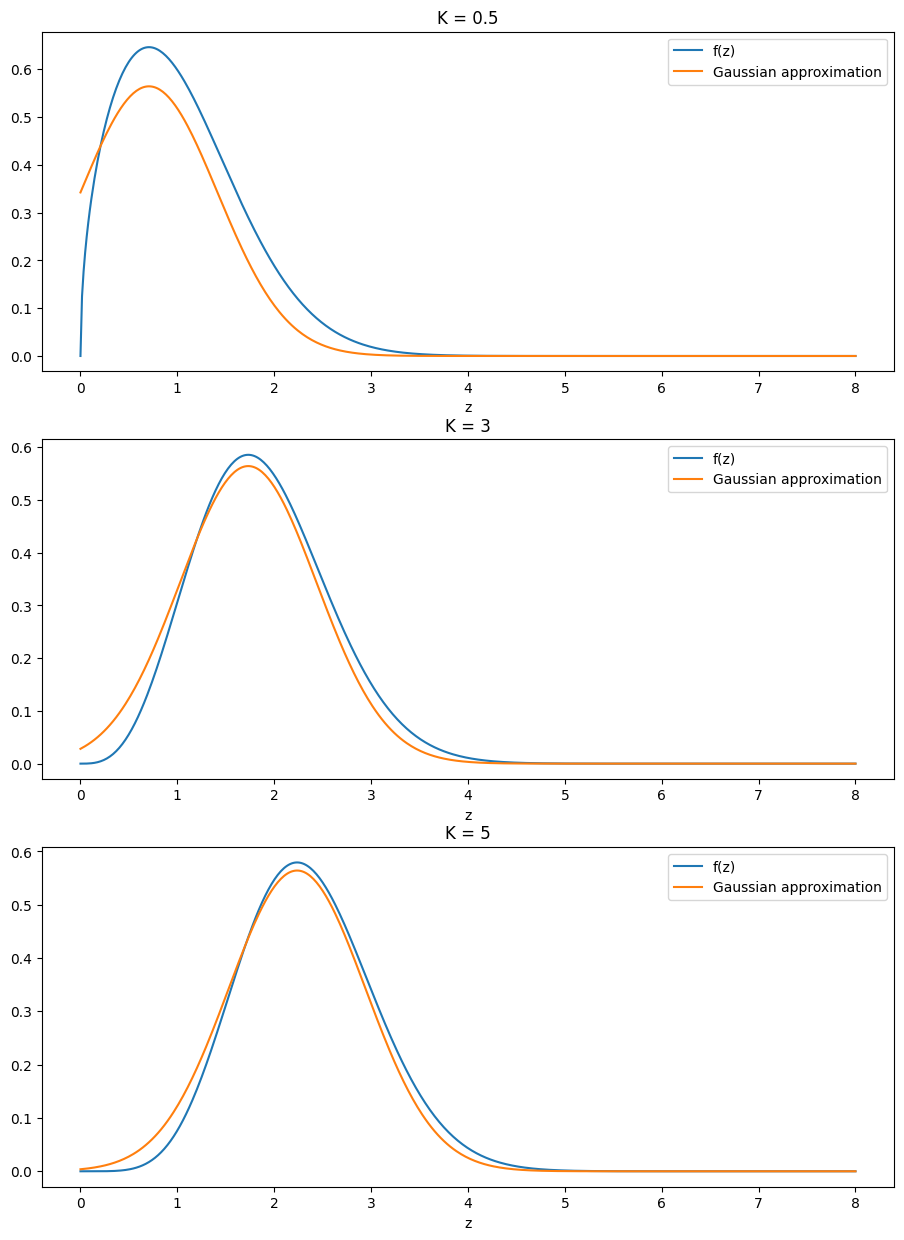

In [101]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

x = np.linspace(0, 8, 500)

def f_norm(z, k):
    return z**k * np.exp(-0.5*z*z) / approx_normalization(k)

fig = plt.figure(figsize=(11, 15))

ax = fig.add_subplot(311)
ax.plot(x, f_norm(x, 0.5), label="f(z)")
ax.plot(x, norm.pdf(x, np.sqrt(0.5), 1/np.sqrt(2)), label="Gaussian approximation")
ax.set_title("K = 0.5")
ax.set_xlabel("z")
ax.legend()

ax = fig.add_subplot(312)
ax.plot(x, f_norm(x, 3), label="f(z)")
ax.plot(x, norm.pdf(x, np.sqrt(3), 1/np.sqrt(2)), label="Gaussian approximation")
ax.set_title("K = 3")
ax.set_xlabel("z")
ax.legend()

ax = fig.add_subplot(313)
ax.plot(x, f_norm(x, 5), label="f(z)")
ax.plot(x, norm.pdf(x, np.sqrt(5), 1/np.sqrt(2)), label="Gaussian approximation")
ax.set_title("K = 5")
ax.set_xlabel("z")
ax.legend()

plt.show()


### <span style="color:blue">Answer to Question 2C.4</span>

It is reasonable to replace the upper limit of $ \infty$ with $ a = 10 $ because when $a \geq 10$ the exponential term in f(z) is less than $e^{-50}$ which is an extremely small number. This exponential dominates more and more as z gets larger, so the total probability mass beyond this point is negligible.

